# SEP Forecasting 
***

Current physics based models of SEPs are unable to execute sufficiently fast in order to
provide actionable information towards forecasting such disturbances, which can impact
Earth within tens of minutes of the onset of an eruptive event. This is compounded by
the intrinsic latency of certain key observations, which are used to define the initial
conditions of these models. Instead, there is a reliance on statistical models to provide
forecast probabilities of Earth-bound SEPs using real-time data. Since the largest, most
impactful events occur infrequently, some regions of the feature space are sparse and
simple discrete binning procedures have limitations. The goal of this project is to
improve upon the empirical SEP proton prediction forecast model (PROTONS) currently
in operational use at SWPC, through the application of modern machine learning
techniques.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from datetime import datetime,timedelta

from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from scipy.sparse import csr_matrix, find


#### Reading in the SEP and control data

In [53]:
#read in the Balch SEP event list
#sepdata = pd.read_excel("SPEall.v7p.xls")

#read in the Balch SEP event list
data = pd.read_excel("ctrlevents.v8p.xls")

In [152]:
#adding y label column indicating positive and negative SEP events - SEP events have Association = ProtonFlare
data['sep'] = (data.Association == "ProtonFlare").astype(int)

# Remove rows where optlocation = nan
data = data[data.optlocation.astype('str') != 'nan']
print(len(data))

#shuffle the events so they are not organized 
data = shuffle(data)

#save the shuffled dataframe -- commented out to prevent resaving
#data.to_csv("AllEvtsShuffled.csv")

3104


#### Make Scatterplot matrix showing relationship between parameters

In [31]:
#pd.plotting.scatter_matrix(sepdata[['Maxflux','FlrPeakFlux','TII_Duration','TIV_duration',\
#                            'FlrIntFlux','FlrIntFlux2','P10MAX','P30MAX','P60MAX',\
#                            'P100MAX','P10FLUENCE','P30FLUENCE','P60FLUENCE','P100FLUENCE']], \
#                            figsize=(18,18), diagonal='kde')

### Logisitic Regression

#### Class to exract features from dataframe that can be used directly

In [153]:
class RawFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        """Class to create original 4 features from Balch 2008"""
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ['FlrPeakFlux','FlrIntFlux','TypeII','TypeIV']
    
    def transform(self, examples):
                
        #Choose the orginal 4 Balch 2008 features (5 if you include both type II and type Iv as separate features)
        #X = examples[['FlrPeakFlux','FlrIntFlux','Type24']]
        X = examples[['FlrPeakFlux','FlrIntFlux','TypeII','TypeIV']]

        return(X)

In [154]:

class FlareTime2Peak(BaseEstimator, TransformerMixin):
    
    """Class to create feature with the time between flare onset to flare max time"""
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ["FlTim2Pk"]
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),1))           

        #time between flare max and flare onset
        X[:,0] = np.asarray([(mx - on).seconds for mx, on in zip(examples.Flrmaxtime, examples.FlrOnset)])
        
        return(X)

In [206]:
class LocationFeatures(BaseEstimator, TransformerMixin):
    
    """Class to create feature with the time between flare onset to flare max time"""
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ['Loc']
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),2))  
        
        #time between flare max and flare onset
        #X[:,0] = np.asarray([str(x)[1:3] for x in examples.optlocation])   #north - south
        #X[:,1] = np.asarray([str(x)[4::] for x in examples.optlocation])   #north - south
        
        for i,loc in enumerate(examples.optlocation):
            lat = str(loc)[1:3]
            if str(loc)[0] == 's' or str(loc)[0] == 'S':
                X[i,0] = -int(lat)
            else:
                X[i,0] = (lat)

            #west-east
            long = str(loc)[4::]
            if str(loc)[3] == 'w' or str(loc)[3] == 'W':
                X[i,1] = -int(long)
            else:
                X[i,1] = int(long)

        return(X)

In [207]:
class SEPClass(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, folds = 3, threshold=0.2):        # <--- other keywords to be used by Feature Union go here
        
        """Class to fit and train Logistic Regression algorithm for SEP forecasting
        
        Input keywords:
        
        folds:        Number of cross validation folds to use
        threshold:    Decision Boundary threshold
        
        """
        
        self.estimator = estimator     #estimator to use for classification e.g. LogReg or SVM
        self.folds = folds             #cross validation folds for estimator
        self.threshold = threshold     #decision boundary threshold
    
        #Set up the Feature union to combine Feature creating classes
        self.allmyfeatures = FeatureUnion([
            ("RawFeat", RawFeatures()),
            ("LocFeatures", LocationFeatures())   #,
            #("FlareTime2Peak", FlareTime2Peak())   #,
            ])
    
    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """  
        
        ##convert columns of time from string to datetime -- MOVE TO SEPARATE CLEANING FUNCTION
        examples.FlrOnset = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrOnset)
        examples.Flrmaxtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrmaxtime)
        examples.Flrendtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrendtime)
        examples.FlrHpTime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrHpTime)
        
        ##convert Type II and Type IV "yes/no" to binary
        examples.TypeII = (examples.TypeII.str.lower() == "yes").astype(int)
        examples.TypeIV = (examples.TypeIV.str.lower() == "yes").astype(int)
        examples['Type24'] = np.logical_or(examples.TypeII, examples.TypeIV)
        
        print(list(examples))
        
        return self.allmyfeatures.fit_transform(examples)
        

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
    
        return self.allmyfeatures.transform(examples)

    def show_topX(self, num=3):
        """
        prints the top num features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray([x.split("__")[1] for x in self.allmyfeatures.get_feature_names()])
        topX = np.argsort(self.estimator.coef_[0])[-num:]
        bottomX = np.argsort(self.estimator.coef_[0])[:num]
        
        print("\nTop 3 features for Pos and Neg\n-------------------------")
        for fn in np.arange(1,num):
            print("Pos %i: %s %f" % (fn, feature_names[topX[-fn]], self.estimator.coef_[0,topX[-fn]]))
        for fn in np.arange(0,num-1):
            print("Neg %i: %s %f" % (fn, feature_names[bottomX[fn]], self.estimator.coef_[0,bottomX[fn]]))

      
    def show_misclassified(self):     

        """
        Method to show the misclassified examples i.e. False Positives and False negatives 
        """
        
        #get all the feature names
        words = feat.allmyfeatures.get_feature_names()
        
        # False positives
        print("\nSome misclassified examples:")
        falsepos = np.where((self.train_pred != self.y_train) & (self.train_pred == 1))[0]   #all false pos example rows
        print("\nPredicted SEP but labeled AllClear (False Pos) \n------------------------- ")

        for i in range(len(falsepos[0:10])):         #loop through falsepos examples
            weights_falsepos = []
            x = find(feat.X_train[falsepos[i]])      #find which features are used for this example
            for ii in x[1]:                          #from sparse matrix get column indices corresponding to features
                weights_falsepos.append((words[ii].split('__')[1], self.estimator.coef_[0,ii]))      #get the word and weight

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i,  example: %s " % \
                (self.y_train[falsepos[i]], self.train_pred[falsepos[i]] , self.train_pred_prob[falsepos[i]][0], \
                     self.train_pred_prob[falsepos[i]][1], falsepos[i], self.clean_examples[falsepos[i]]))
            for j in weights_falsepos:
                print(j)
                
        # False Negatives
        falseneg = np.where((self.train_pred != self.y_train) & (self.train_pred == 0))[0]
        print("\nPredicted AllClear but labeled SEP (False Neg) \n-------------------------")

        for i in range(len(falseneg[0:10])):
            weights_falseneg = []
            x = find(feat.X_train[falseneg[r]])
            for ii in x[1]:
                weights_falseneg.append((words[ii].split('__')[1], self.estimator.coef_[0,ii])) 

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i, \nexample: %s " % \
                (self.y_train[falseneg[i]], self.train_pred[falseneg[i]], self.train_pred_prob[falseneg[i]][0], \
                 self.train_pred_prob[falseneg[i]][1], falseneg[i], self.clean_examples[falseneg[i]]))
            for j in weights_falseneg:
                print(j)
        
        print("\n\n")
       

    def score(self, X, y):

        """find the accuracy score given the training data and labels"""
        print("...In Score...")
        print("threshold:", self.threshold)
        y_pred = (self.estimator.predict(X) > self.threshold).astype(int)
        
        return accuracy_score(y, y_pred)
        
    def fit(self, X, y):    #, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        #self.dfTrain = pd.read_csv("AllEvtsShuffled.csv")
                      
        # get training features and labels 
        #self.X_train = self.build_train_features(self.dfTrain)    #CHANGE
        #self.y_train = np.array(self.dfTrain.sep, dtype=int)
        
        self.X_train = X
        self.y_train = y
        
        #print the shape of the features
        print("Shape of the Features: Num examples x Num Features")
        print(self.X_train.shape)
        print("examples...:", self.X_train[0:10])

        #self.logreg.fit(self.X_train, self.y_train)
        self.estimator.fit(self.X_train, self.y_train)
        
        # make predictions on training data 
        self.train_pred = self.estimator.predict(self.X_train)

        #return the LogReg probabilities used to classify each example  
        self.train_pred_prob = self.estimator.predict_proba(self.X_train)
        
        #print("\nTraining Set\n-------------------------")
        #self.score(self.train_pred, self.y_train)
             
        #cross validation
 
        #print("\nCross Validation Accuracy Scores (cross_val_score)\n-------------------------")
        #scores = cross_val_score(self.estimator, self.X_train, self.y_train, cv=self.folds)
        #print(scores)
        #print("\nMean Accuracy in Cross-Validation = %.3f \n" % scores.mean())
        
        #cross validation
        #print("\nCross Validation Accuracy Scores (cross_val_predict)\n-------------------------")
        #self.y_pred = cross_val_predict(self.estimator, self.X_train, self.y_train, cv=self.folds)
        #print(self.score(self.y_pred, self.y_train))
        
        #print("\nCross Confusion Matrix\n-------------------------")
        #self.conf_mat = confusion_matrix(self.y_train,self.y_pred)
        #tn, fp, fn, tp = self.conf_mat.ravel()
        #print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i" % (tp,tn,fp,fn))

        
    def predict(X):
        
        """
        Return predicted labels for exmaples X. 
 
        #### CURRENTLY THIS FUNCTION ISN'T USED - but could be called if we need predicted y vals 
        #### independently to the score function
 
        """
        print("INside predict....")
        print("Thresh: ", self.threshold)
        return (self.estimator.predict(X) > self.threshold).astype(int)
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        
        #### CURRENTLY THIS FUNCTION ISN'T USED - leftover from FeatEngr homework but we might need to
        #### to test on the holy grail test set
        """
        
        # read in test data 
        dfTest  = pd.read_csv("../data/spoilers/test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(list(dfTest["sentence"]))
        
        # make predictions on test data 
        pred = self.estimator.predict(self.X_test)
        
        # dump predictions to file for submission to Kaggle  
        #pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")
        
                

In [208]:
#Initialize SEPClass instance with an estimator of choice - here Logisitic Regression
#with estimator specific keywords 
keywords = {'random_state':1230, 'max_iter':100}
sep = SEPClass(LogisticRegression(**keywords) )

# load data - for the gridsearcv the data needs to be loaded outside of the class
dfTrain = pd.read_csv("AllEvtsShuffled.csv")
                      
# get training features and labels 
X_train = sep.build_train_features(dfTrain)    #CHANGE
y_train = np.array(dfTrain.sep, dtype=int)

#Turn off features that aren't fully fleshed out or don't work
#sep.allmyfeatures.set_params(FlareTime2Peak=None)

#train the model
sep.fit(X_train, y_train)

['Unnamed: 0', 'FlrOnset', 'Flrmaxtime', 'Flrendtime', 'FlrPeakFlux', 'xrscls', 'ocls', 'optlocation', 'region', 'Rpatrol', 'TypeII', 'TII_duration', 'TypeIV', 'TIV_duration', 'CME_Patrol', 'CME_onset', 'CME_speed', 'Satellite', 'FlrHpTime', 'FlrIntFlux', 'FlrIntFlux2', 'Association', 'S1onset', 'S2onset', 'S3onset', 'S4onset', 'S5onset', 'GT100onset', 'sep', 'Type24']
Shape of the Features: Num examples x Num Features
(3104, 6)
examples...: [[  6.56000000e-06   2.20000000e-02   0.00000000e+00   0.00000000e+00
    2.90000000e+01   6.20000000e+01]
 [  5.53000000e-06   1.28000000e-02   0.00000000e+00   0.00000000e+00
   -3.80000000e+01  -5.80000000e+01]
 [  1.11000000e-05   3.68000000e-02   0.00000000e+00   0.00000000e+00
   -1.40000000e+01  -7.20000000e+01]
 [  1.19000000e-05   3.23000000e-02   0.00000000e+00   0.00000000e+00
    1.60000000e+01   3.40000000e+01]
 [  1.56000000e-05   8.67000000e-02   0.00000000e+00   1.00000000e+00
   -1.10000000e+01   3.00000000e+00]
 [  1.03000000e-04 

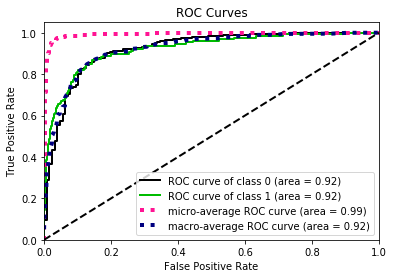

In [209]:
# Initial implementation of ROC plot applied to training set
import scikitplot as skplt

# Can instead pull this from fit method above
probas = sep.estimator.predict_proba(sep.X_train) 


skplt.metrics.plot_roc_curve(y_train, probas)

In [210]:
from sklearn.metrics import confusion_matrix

# Can instead pull this from fit method above
probas = sep.estimator.predict_proba(sep.X_train) 

# Add confusion Matrix
preds = sep.estimator.predict(sep.X_train)
tn, fp, fn, tp=confusion_matrix(y_train, preds).ravel()

#tn, fp, fn, tp = conf_mat.ravel()
print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i" % (tp,tn,fp,fn))

from sklearn.metrics import mean_squared_error as mse
mserr = mse(y_train, preds)
print("MSE:", mserr)

from sklearn.metrics import brier_score_loss as bsl
bsloss = bsl(y_train, probas[:,1])
print("BSL:", bsloss)

occ_rate = y_train.sum()/len(y_train)

QR_star = 0.0324
#QR_star =  mse(y_train, np.zeros(len(y_train)))
print("RefQuadScore: ", QR_star)

QR = 0.0250
SS = (QR_star - QR)/QR_star

print("SS: ", SS)


FAR = fp/(tp + fp)
POD = tp/(tp + fn)

print("FAR: ", FAR)
print("POD: ", POD)


True Pos: 28, True Neg: 2969, False Pos: 8,. False Neg: 99
MSE: 0.0344716494845
BSL: 0.0269261246974
RefQuadScore:  0.0324
SS:  0.22839506172839497
FAR:  0.222222222222
POD:  0.220472440945


In [162]:
#this Cell runs the GridSearchCV 

#this line sets up the SEP class with a logistic regression model with keyword arguements keywords
keywords = {'random_state':1230}
model_to_set = SEPClass(LogisticRegression(**keywords))
#model_to_set.allmyfeatures.set_params(FlareTime2Peak=None)      #this doesn't seem to work, 
                                                                #need to figure out how to turn off features
                                                                #shape of features should change

#these are the keywords we want to tune in Logisitic REgression
parameters = {
    "estimator__max_iter": [100,150,200],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters)
model_tunning.fit(X_train, y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

Shape of the Features: Num examples x Num Features
(2068, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2070, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2070, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2068, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2070, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2070, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2068, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examples x Num Features
(2070, 4)
...In Score...
threshold: 0.2
...In Score...
threshold: 0.2
Shape of the Features: Num examp